# YOLOv8 Detection Training with Synthetic A4


---

1. Include all needed libraires.

In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from google.colab import drive
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
import shutil
import albumentations as A
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Setup.



In [18]:
# Set desired path inside Drive
DRIVE_PROJECT_DIR = Path("/content/drive/MyDrive/NumberDetect")
IMAGES_DIR = DRIVE_PROJECT_DIR / "images"
LABELS_DIR = DRIVE_PROJECT_DIR / "labels"

# Create folders if they don’t exist
DRIVE_PROJECT_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
LABELS_DIR.mkdir(parents=True, exist_ok=True)

3. Generate synthetic image and dataset.

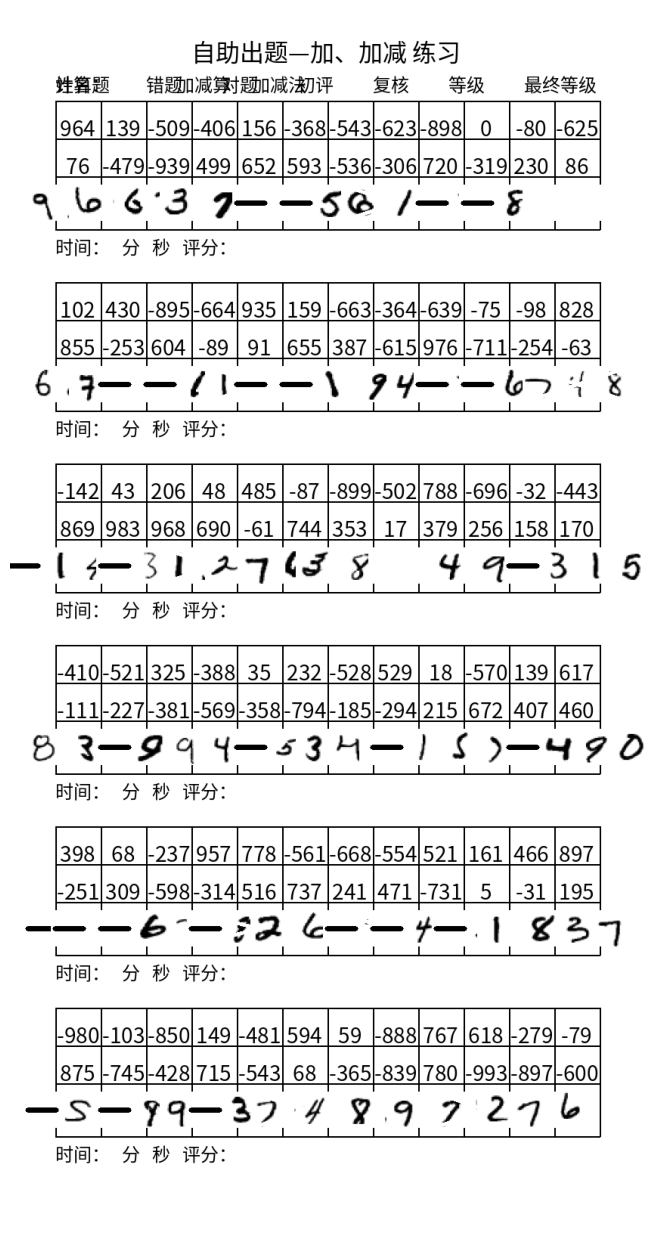

In [ ]:
# --- Install dependencies and download font ---
!pip install pillow opencv-python matplotlib albumentations --quiet
!wget -O NotoSansCJKsc-Regular.otf "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf" --quiet

# Set desired path inside Drive 
DRIVE_PROJECT_DIR = Path("/content/drive/MyDrive/NumberDetect")
IMAGES_DIR = DRIVE_PROJECT_DIR / "images"
LABELS_DIR = DRIVE_PROJECT_DIR / "labels"

# Create folders if they don't exist
DRIVE_PROJECT_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
LABELS_DIR.mkdir(parents=True, exist_ok=True)

# Clean old dataset
for folder in [IMAGES_DIR, LABELS_DIR]:
    for file in folder.glob("worksheet_*.jpg"):
        file.unlink()
    for file in folder.glob("worksheet_*.txt"):
        file.unlink()

# --- Parameters ---
num_samples = 200  # Increased for better training

# --- MNIST loading ---
(_, _), (x_test, y_test) = mnist.load_data()

# --- Background augmentation ---
background_augment = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.GaussNoise(var_limit=(5.0, 25.0), p=0.2),
    A.MotionBlur(blur_limit=2, p=0.1),
    A.Rotate(limit=2, p=0.1),  # Slight rotation
])

# --- Helper functions ---
def get_digit_img(digit, size=40):
    indices = np.where(y_test == digit)[0]
    idx = np.random.choice(indices)
    img = x_test[idx]
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    return img

def get_number_img(number, size=35):
    str_num = str(number)
    imgs = []
    for char in str_num:
        if char == '-':
            img = np.zeros((size, size), dtype=np.uint8)
            cv2.line(img, (5, size//2), (size-5, size//2), 255, 5)
        else:
            img = get_digit_img(int(char), size)
        imgs.append(img)
    return np.hstack(imgs)

def cross_out_varied(img):
    """Enhanced cross_out with multiple patterns and thicker lines"""
    img = img.copy()
    h, w = img.shape
    pattern = random.choice(["double", "thick", "multiple", "dashed", "dotted"])
    
    if pattern == "double":
        # Two parallel crosses
        for offset in [5, 15]:
            cv2.line(img, (0+offset, 0+offset), (w-1-offset, h-1-offset), 0, 12)
            cv2.line(img, (w-1-offset, 0+offset), (0+offset, h-1-offset), 0, 12)
    
    elif pattern == "thick":
        # Very thick single cross
        cv2.line(img, (0, 0), (w-1, h-1), 0, 20)
        cv2.line(img, (w-1, 0), (0, h-1), 0, 20)
    
    elif pattern == "multiple":
        # Multiple thin crosses
        for i in range(3):
            offset = i * 8
            cv2.line(img, (0+offset, 0+offset), (w-1-offset, h-1-offset), 0, 8)
            cv2.line(img, (w-1-offset, 0+offset), (0+offset, h-1-offset), 0, 8)
    
    elif pattern == "dashed":
        # Dashed line effect
        for i in range(0, max(h, w), 15):
            cv2.line(img, (i, i), (min(i+10, w-1), min(i+10, h-1)), 0, 12)
            cv2.line(img, (w-1-i, i), (max(w-1-i-10, 0), min(i+10, h-1)), 0, 12)
    
    elif pattern == "dotted":
        # Dotted line effect
        for i in range(0, max(h, w), 8):
            cv2.circle(img, (i, i), 4, 0, -1)
            cv2.circle(img, (w-1-i, i), 4, 0, -1)
    
    return img

def cross_out_distinct(img):
    """Cross with visual distinction from valid numbers"""
    img = img.copy()
    h, w = img.shape
    
    # Add a background rectangle behind the cross
    cv2.rectangle(img, (2, 2), (w-3, h-3), 128, -1)  # Gray background
    
    # Draw thick white cross on gray background
    cv2.line(img, (0, 0), (w-1, h-1), 255, 15)
    cv2.line(img, (w-1, 0), (0, h-1), 255, 15)
    
    return img

def paint_out(img):
    """Enhanced paint_out with more variety"""
    img = img.copy()
    h, w = img.shape
    
    paint_style = random.choice(["scribble", "solid", "partial", "noise"])
    
    if paint_style == "scribble":
        # Multiple thick scribbles
        for _ in range(random.randint(4, 8)):
            x1, y1 = random.randint(0, w//2), random.randint(0, h)
            x2, y2 = random.randint(w//2, w), random.randint(0, h)
            cv2.line(img, (x1, y1), (x2, y2), 0, random.randint(10, 18))
    
    elif paint_style == "solid":
        # Solid black rectangle
        cv2.rectangle(img, (0, 0), (w, h), 0, -1)
    
    elif paint_style == "partial":
        # Partially painted out
        cv2.rectangle(img, (w//4, h//4), (3*w//4, 3*h//4), 0, -1)
        # Add some scribbles around edges
        for _ in range(3):
            x1, y1 = random.randint(0, w), random.randint(0, h//4)
            x2, y2 = random.randint(0, w), random.randint(3*h//4, h)
            cv2.line(img, (x1, y1), (x2, y2), 0, random.randint(8, 12))
    
    elif paint_style == "noise":
        # Noise-based painting
        noise = np.random.randint(0, 100, (h, w), dtype=np.uint8)
        mask = noise < 70  # 70% black pixels
        img[mask] = 0
    
    return img

def add_paper_noise(img, strength=20):
    arr = np.array(img).astype(np.int16)
    noise = np.random.normal(0, strength, arr.shape)
    arr = arr + noise
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

# --- Worksheet layout parameters ---
blocks = 6
cols_per_block = 12
rows_per_block = 2  # question (2 lines) + answer

cell_w, cell_h = 140, 70
answer_cell_h = 90  # Make answer field bigger
block_gap = 30
left_margin, top_margin = 60, 120

img_w = left_margin * 2 + cols_per_block * cell_w
img_h = top_margin + blocks * (cell_h*2 + answer_cell_h + 40) + block_gap * (blocks-1) + 100

# Chinese font
font_path = "NotoSansCJKsc-Regular.otf"
font = ImageFont.truetype(font_path, 32)
font_small = ImageFont.truetype(font_path, 24)
cell_font = ImageFont.truetype(font_path, 28)

# --- Dataset generation loop ---
for idx in tqdm(range(num_samples)):
    img = Image.new("L", (img_w, img_h), 255)
    draw = ImageDraw.Draw(img)
    yolo_labels = []

    # Draw title and headers
    draw.text((img_w//2-180, 30), "自助出题—加、加减 练习", font=font, fill=0)
    draw.text((left_margin, 80), "姓名：", font=font_small, fill=0)
    draw.text((left_margin+160, 80), "加减算", font=font_small, fill=0)
    draw.text((left_margin+260, 80), "加减法", font=font_small, fill=0)

    # Table headers
    header_y = top_margin - 40
    draw.text((left_margin, header_y), "计算题", font=font_small, fill=0)
    draw.text((left_margin+120, header_y), "错题", font=font_small, fill=0)
    draw.text((left_margin+220, header_y), "对题", font=font_small, fill=0)
    draw.text((left_margin+320, header_y), "初评", font=font_small, fill=0)
    draw.text((left_margin+420, header_y), "复核", font=font_small, fill=0)

    # Force balanced distribution per worksheet
    total_cells = blocks * cols_per_block
    valid_count = int(total_cells * 0.4)  # 40% valid
    blank_count = int(total_cells * 0.25)  # 30% blank (reduce false positives)
    cross_count = int(total_cells * 0.2)  # 20% crossed
    paint_count = total_cells - valid_count - blank_count - cross_count  # 15% painted

    cell_types = (["number"] * valid_count + 
                 ["blank"] * blank_count + 
                 ["cross"] * cross_count + 
                 ["paint"] * paint_count)
    random.shuffle(cell_types)
    
    cell_idx = 0

    # Generate blocks
    for block in range(blocks):
        y0 = top_margin + block * (cell_h*2 + answer_cell_h + 40 + block_gap)
        
        # Draw block header
        draw.text((left_margin, y0-30), f"第{block+1}组", font=font_small, fill=0)
        
        for col in range(cols_per_block):
            # Generate two random questions (normal font)
            question1 = random.randint(-999, 999)
            question2 = random.randint(-999, 999)
            q1_str = str(question1)
            q2_str = str(question2)
            cell_x = left_margin + col * cell_w
            cell_y1 = y0
            cell_y2 = y0 + cell_h
            bbox1 = cell_font.getbbox(q1_str)
            w1, h1 = bbox1[2] - bbox1[0], bbox1[3] - bbox1[1]
            q1_offset_x = cell_x + (cell_w - w1)//2
            q1_offset_y = cell_y1 + (cell_h - h1)//2

            # Draw and label question 1
            draw.text((q1_offset_x, q1_offset_y), q1_str, font=cell_font, fill=0)
            # Add YOLO label for question 1 (class 3)
            x_center1 = (q1_offset_x + w1/2) / img_w
            y_center1 = (q1_offset_y + h1/2) / img_h
            w_norm1 = w1 / img_w
            h_norm1 = h1 / img_h
            yolo_labels.append(f"3 {x_center1:.6f} {y_center1:.6f} {w_norm1:.6f} {h_norm1:.6f}")
            bbox2 = cell_font.getbbox(q2_str)
            w2, h2 = bbox2[2] - bbox2[0], bbox2[3] - bbox2[1]
            q2_offset_x = cell_x + (cell_w - w2)//2
            q2_offset_y = cell_y2 + (cell_h - h2)//2

            # Draw and label question 2
            draw.text((q2_offset_x, q2_offset_y), q2_str, font=cell_font, fill=0)
            # Add YOLO label for question 2 (class 3)
            x_center2 = (q2_offset_x + w2/2) / img_w
            y_center2 = (q2_offset_y + h2/2) / img_h
            w_norm2 = w2 / img_w
            h_norm2 = h2 / img_h
            yolo_labels.append(f"3 {x_center2:.6f} {y_center2:.6f} {w_norm2:.6f} {h_norm2:.6f}")
            
            # Generate answer (bottom cell)
            ans_cell_y = y0 + 2*cell_h

            cell_type = cell_types[cell_idx]
            cell_idx += 1
            
            # YOLO class mapping
            if cell_type == "number":
                class_id = 0
                answer = random.randint(-999, 999)
                num_img = get_number_img(answer, size=35)
                num_pil = Image.fromarray(num_img)
                
            elif cell_type == "cross":
                class_id = 1
                answer = random.randint(-999, 999)
                num_img = get_number_img(answer, size=35)
                # Use enhanced cross_out function
                if random.random() < 0.7:
                    num_img = cross_out_varied(num_img)
                else:
                    num_img = cross_out_distinct(num_img)
                num_pil = Image.fromarray(num_img)
                
            elif cell_type == "paint":
                class_id = 2
                answer = random.randint(-999, 999)
                num_img = get_number_img(answer, size=35)
                num_img = paint_out(num_img)
                num_pil = Image.fromarray(num_img)
                
            else:  # blank
                class_id = None  # Do not label blank cells
                num_pil = None
            
            # Paste answer cell if it exists
            if num_pil is not None:
                # Center the answer in the 
                # Add slight random offset for realism
                rand_offset_x = random.randint(-5, 5)  # You can adjust the range
                rand_offset_y = random.randint(-3, 3)
                paste_x = cell_x + (cell_w - num_pil.width)//2 + rand_offset_x
                paste_y = ans_cell_y + (answer_cell_h - num_pil.height)//2 + rand_offset_y
                img.paste(num_pil, (paste_x, paste_y))
                
                # YOLO label (normalized coordinates)
                x_center = (cell_x + cell_w//2) / img_w
                y_center = (ans_cell_y + answer_cell_h//2) / img_h
                width = cell_w / img_w
                height = answer_cell_h / img_h
                
                yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            
            # Draw cell borders
            draw.rectangle([cell_x, cell_y, cell_x+cell_w, cell_y+cell_h], outline=0, width=1)
            draw.rectangle([cell_x, cell_y+cell_h, cell_x+cell_w, cell_y+cell_h*2], outline=0, width=1)
            draw.rectangle([cell_x, ans_cell_y, cell_x+cell_w, ans_cell_y+answer_cell_h], outline=0, width=1)

    # Apply background augmentation to reduce false positives
    img_array = np.array(img)
    augmented = background_augment(image=img_array)['image']
    img = Image.fromarray(augmented)
    strength = random.randint(1, 15)
    img = add_paper_noise(img, strength=strength)
    
    # Save image and labels
    img.save(IMAGES_DIR / f"worksheet_{idx+1:04d}.jpg")
    
    with open(LABELS_DIR / f"worksheet_{idx+1:04d}.txt", "w") as f:
        f.write("\n".join(yolo_labels))

print(f"Generated {num_samples} worksheets with balanced classes:")
print(f"- Valid numbers: ~{valid_count} per worksheet")
print(f"- Blank cells: ~{blank_count} per worksheet (reduces false positives)")
print(f"- Crossed out: ~{cross_count} per worksheet (enhanced patterns)")
print(f"- Painted out: ~{paint_count} per worksheet (varied styles)")

# Show a sample
plt.figure(figsize=(15, 10))
sample_img = Image.open(IMAGES_DIR / "worksheet_0001.jpg")
plt.imshow(sample_img, cmap='gray')
plt.title("Sample Generated Worksheet with Improvements")
plt.axis('off')
plt.show()

4. Split train and val images.

In [ ]:
import shutil
import random
from pathlib import Path

# Shuffle images
image_files = list((IMAGES_DIR).glob("*.jpg"))
random.shuffle(image_files)

# Split 80% train, 20% val
split_index = int(len(image_files) * 0.8)
train_images = image_files[:split_index]
val_images = image_files[split_index:]

# Create train/val dirs
for split in ['train', 'val']:
    (IMAGES_DIR / split).mkdir(parents=True, exist_ok=True)
    (LABELS_DIR / split).mkdir(parents=True, exist_ok=True)

# Move image-label pairs into train/val
for img_path in train_images:
    label_path = LABELS_DIR / (img_path.stem + ".txt")
    shutil.move(str(img_path), str(IMAGES_DIR / "train" / img_path.name))
    shutil.move(str(label_path), str(LABELS_DIR / "train" / label_path.name))

for img_path in val_images:
    label_path = LABELS_DIR / (img_path.stem + ".txt")
    shutil.move(str(img_path), str(IMAGES_DIR / "val" / img_path.name))
    shutil.move(str(label_path), str(LABELS_DIR / "val" / label_path.name))


5. Visualize sample data.

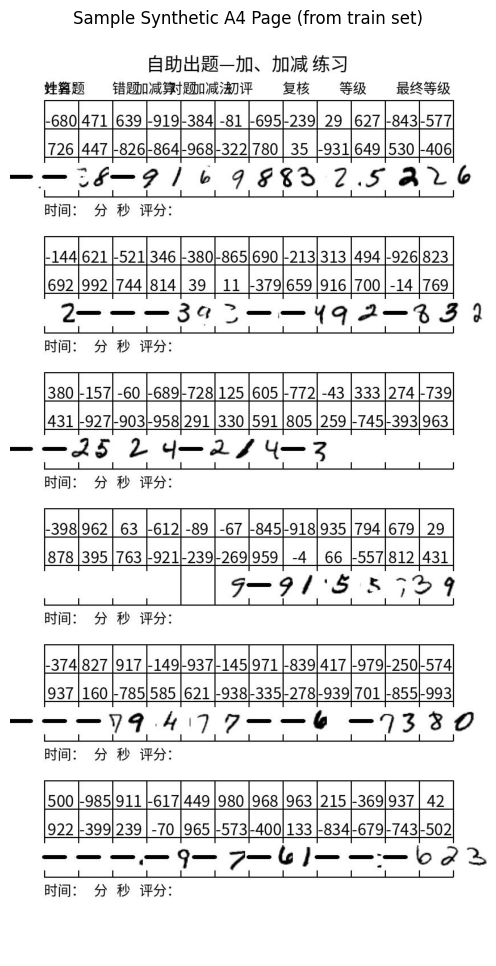

In [27]:
sample_path = IMAGES_DIR / "train" / "worksheet_0003.jpg"
if sample_path.exists():
    sample_img = cv2.imread(str(sample_path))
    plt.figure(figsize=(10,12))
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Sample Synthetic A4 Page (from train set)")
    plt.show()
else:
    print(f"Sample image not found at: {sample_path}")

6. Training YOLOv8 model

In [ ]:
!pip install ultralytics --quiet
from ultralytics import YOLO

yaml_content = f"""
path: {DRIVE_PROJECT_DIR}
train: images/train
val: images/val

names:
  0: valid
  1: crossed_out
  2: painted_out
  3: question
"""
with open(DRIVE_PROJECT_DIR / "data.yaml", "w") as f:
    f.write(yaml_content)

DRIVE_PROJECT_DIR = Path("/content/drive/MyDrive/NumberDetect")

# Load and train YOLOv8 (nano model for speed)
model = YOLO("yolov8n.pt")
model.train(data=str(DRIVE_PROJECT_DIR / "data.yaml"), epochs=20, imgsz=640)

# Evaluate the model
results = model.val()

# Print main metrics
print("\n Evaluation Results:")
print(f"mAP@0.5: {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

# Export to ONNX and TFLite formats
model.export(format="onnx")
model.export(format="tflite")


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/NumberDetect/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning /content/drive/MyDrive/NumberDetect/labels/train.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 86.7±11.5 MB/s, size: 209.9 KB)



val: Scanning /content/drive/MyDrive/NumberDetect/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to runs/detect/train5/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      3.474      4.197      1.872       1100        640: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20         0G      3.367      4.198      1.814       1156        640: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/20         0G      3.303      4.184      1.789       1057        640: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/20         0G      3.095      4.177      1.665       1108        640: 100%|██████████| 1/1 [00:07<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/20         0G      2.736      4.131      1.675        746        640: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/20         0G      2.749      4.105      1.483       1261        640: 100%|██████████| 1/1 [00:07<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/20         0G      2.438      4.061       1.45       1032        640: 100%|██████████| 1/1 [00:06<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          4        263          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/20         0G      2.273       4.03      1.317       1210        640: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          4        263    0.00142    0.00175   0.000716    0.00043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/20         0G       2.21       3.98       1.26       1234        640: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all          4        263     0.0133     0.0745    0.00711    0.00423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/20         0G      1.894      3.913      1.185       1092        640: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4        263     0.0441      0.227     0.0275     0.0164


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G       1.52      3.722      1.048        626        640: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all          4        263       0.08      0.347     0.0634     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.469      3.647      1.019        616        640: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all          4        263     0.0736      0.245     0.0593     0.0371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/20         0G      1.372      3.555      1.018        605        640: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all          4        263     0.0537       0.14     0.0381     0.0248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/20         0G      1.655      3.437      1.027        626        640: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          4        263     0.0389     0.0942     0.0249     0.0171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/20         0G      1.532      3.384     0.9644        649        640: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all          4        263     0.0173     0.0384    0.00979     0.0066

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/20         0G      1.132       3.23     0.9598        605        640: 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          4        263   0.000827    0.00175   0.000689   0.000138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.171      3.162     0.9448        617        640: 100%|██████████| 1/1 [00:05<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          4        263   0.000811    0.00175   0.000737   0.000147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/20         0G      1.134      3.159     0.9251        637        640: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all          4        263   0.000811    0.00175   0.000737   0.000147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/20         0G      1.273       2.99        0.9        615        640: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all          4        263   0.000807    0.00175   0.000735   7.35e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/20         0G      1.168      3.086     0.8987        613        640: 100%|██████████| 1/1 [00:05<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all          4        263   0.000807    0.00175   0.000735   7.35e-05

20 epochs completed in 0.039 hours.


Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


                   all          4        263     0.0808      0.349      0.064     0.0377
                 valid          4        191      0.224      0.576      0.177      0.103
           crossed_out          4         55          0          0          0          0
           painted_out          2         17     0.0185      0.471     0.0148     0.0102
Speed: 0.6ms preprocess, 88.1ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to runs/detect/train5
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 99.3±14.0 MB/s, size: 209.9 KB)


val: Scanning /content/drive/MyDrive/NumberDetect/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


                   all          4        263     0.0808      0.349      0.064     0.0377
                 valid          4        191      0.224      0.576      0.177      0.103
           crossed_out          4         55          0          0          0          0
           painted_out          2         17     0.0185      0.471     0.0148     0.0102
Speed: 0.5ms preprocess, 88.5ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to runs/detect/train52

 Evaluation Results:
mAP@0.5: 0.0640
mAP@0.5:0.95: 0.0377
Precision: 0.0808
Recall: 0.3488
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.5s
WARNING ⚠️ requirements: Restart runtim

100%|██████████| 1.11M/1.11M [00:00<00:00, 33.5MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 56.88file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 1.0s, saved as 'runs/detect/train5/weights/best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.1...
Saved artifact at 'runs/detect/train5/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 7, 8400), dtype=tf.float32, name=None)
Captures:
  137117472722960: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137117472722576: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  137117472723344: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  137117472727184: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137117472726800: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  137117472727760: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137117472723152: TensorSpec(shape=(1, 1

'runs/detect/train5/weights/best_saved_model/best_float32.tflite'

7. Consfusion Matrix

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import glob

# Find the latest validation folder
import os
val_dirs = sorted(glob.glob('runs/detect/train*'), key=os.path.getmtime)
if val_dirs:
    cm_path = os.path.join(val_dirs[-1], 'confusion_matrix.png')
    if os.path.exists(cm_path):
        img = Image.open(cm_path)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title('YOLOv8 Confusion Matrix')
        plt.show()
    else:
        print("No confusion_matrix.png found in the latest val directory.")
else:
    print("No validation results found.")

AttributeError: 'DetMetrics' object has no attribute 'plot'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (Dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (Dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (Dict[str, List]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.
    